# Assignment 4: Evaluation Metrics + Manipulating Attention Heads in Transformers (TA: Karan Raj Bagri)

The goal of this assignment is to show how different attention heads have varying significance for transformers trained on multiple tasks by computing gradient-based importance scores, selectively pruning less critical heads, and evaluating the impact on performance.

Please make a copy of this notebook (locally or on Colab). Ensure you adhere to the guidelines and submission instructions (mentioned below) for attempting and submitting the assignment.

Given that the class has 150+ students, we will **NOT** entertain any requests for changing your notebooks after the submission deadline (especially in cases when the notebook fails to compile or run because you did not follow the instructions).

### Guidelines for Attempting the Assignment

1. Write your logic in the cells **ONLY** which have the comment `# ADD YOUR CODE HERE`, between the `# BEGIN CODE` and `# END CODE` comments. These cells are also demarcated by the special start (`## ==== BEGIN EVALUATION PORTION`) and end (`## ==== END EVALUATION PORTION`) comments. Do **NOT** remove any of these comments from the designated cells, otherwise your assignment will not be evaluated correctly.

2. All imports that should be necessary are already provided as part of the notebook. You should **NOT** import any new libraries, otherwise your assignment will not be graded.

3. You need to install the libraries/imports used in this notebook yourself. Its recommended to use python version between 3.9 and 3.11 to attempt this assignment.

4. Only write your code in the cells designated for auto-evaluation. If you encounter any errors in the supporting cells during execution, contact the respective TAs.

5. **Please read the function docs and comments carefully**. They provide specific instructions and examples for implementing each function. Follow these instructions precisely - neither oversimplify nor overcomplicate your implementations. Deviating from the provided implementation guidelines may result in lost marks.

6. **Important**: Use of AI-assistive technologies such as ChatGPT or GitHub CoPilot is not permitted for this assignment. Ensure that all attempts are solely your own. Not following this rule can incur a large penalty, including but not limited to scoring a zero for this assignment.

### Submission Instructions

1. Ensure your code follows all guidelines mentioned above before submission.

2. Ensure you only add code in designated areas, otherwise your assignment will not evaluated.

3. When you have completely attempted the assignment, export the current notebook as a `.py` file, with the following name: `SAPName_SRNo_assignment4.py`, where `SAPName` would be your name as per SAP record, and `SRNo` will be the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use `Twyla_Linda_15329_assignment4.py`.

4. You should put your assignment file `SAPName_SRNo_assignment4.py` inside a folder `SAPName_SRNo`. The folder structure looks as follows:

``` python
└─── SAPName_SRNo
     ├─── SAPName_SRNo_assignment4.py
```

5. When you run the assignment code, it may download certain datasets and other artifacts. These should **NOT** be part of the above folder.

6. Once you have validated the folder structure as above, zip the folder and name it as `SAPName_SRNo_assignment4.zip` and submit this ZIP archive.

7. Please ensure that your notebook finishes execution of all the cells within 30 minutes.

### Marks Distribution

- Evaluation Metrics: 30 marks
- Head Importance Analysis: 20 marks
- Pruning: 50 marks

# Imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [2]:
import math
from typing import List
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import IPython.display as display

2025-04-19 14:55:19.989355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745074520.179293      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745074520.233756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Evaluation Metrics

### ROUGE-L

The ROUGE-L metric evaluates text summarization quality by measuring the Longest Common Subsequence (LCS) between a machine-generated summary and a reference summary.

ROUGE-L is particularly useful for assessing how well a summary captures the main ideas while maintaining sentence-level structure similarity. It doesn't require consecutive matches, making it more flexible than strict n-gram methods.

You may look at section 3.1 of the [original ROUGE paper by Lin (2004)](https://aclanthology.org/W04-1013/) and implement sentence-level LCS.

In [3]:
## ==== BEGIN EVALUATION PORTION
def rouge_l(prediction: str, reference: str, beta=1) -> float:
    """
    Computes the ROUGE-L F measure based on the Longest Common Subsequence (LCS).

    ROUGE-L measures the similarity between summaries by finding the longest sequence
    of words that appear in the same relative order in both texts. It computes precision
    (the proportion of words in the prediction that are part of the LCS) and recall
    (the proportion of words in the reference that are part of the LCS), and then combines
    them using an F measure.

    The F measure is computed as:
        F_beta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    where beta determines the weight of recall relative to precision.
    - A beta of 1.0 (default) gives equal weight to precision and recall (the F1 score).
    - A beta greater than 1 emphasizes recall, while a beta less than 1 emphasizes precision.

    Parameters:
        prediction (str): The machine-generated or candidate summary text.
        reference (str): The human-written or ground truth summary text.
        beta (float): The weight factor for recall relative to precision. Default is 1.0.

    Returns:
        float: The ROUGE-L F measure between 0.0 and 1.0, where higher values indicate
               greater similarity between the prediction and reference.

    Example:
        >>> rouge_l("The cat is on the mat", "The cat sat on the mat")
        0.83  # (approximately)

    Notes:
        - The function tokenizes inputs by splitting on whitespace and converting to lowercase.
        - Returns 0.0 if either input is empty.
        - No external libraries (e.g., NLTK) should be used to compute the result.
    """

    # BEGIN CODE : eval1.rouge_l
    # ADD YOUR CODE HERE

    #Compute the length of the two strings
    len_prediction = len(prediction.split())
    len_reference = len(reference.split())
    prediction = prediction.lower().split()
    reference = reference.lower().split()

    #Return 0.0 if either input is empty
    if len_prediction == 0 or len_reference == 0:
        return 0.0

    #Compute the LCS of the two string
    LCS = torch.zeros(len_prediction + 1, len_reference + 1)
    for i in range(len_prediction):
        for j in range(len_reference):
          if prediction[i] == reference[j]:
            LCS[i+1, j+1] = LCS[i, j] + 1
          else:
            LCS[i+1, j+1] = max(LCS[i, j+1], LCS[i+1, j])

    #Compute the precision and recall
    precision = LCS[len_prediction, len_reference] / len_prediction
    recall = LCS[len_prediction, len_reference] / len_reference

    #Compute the F measure
    F = ((1 + beta) * precision * recall) / (beta * precision + recall)

    #Return the F measure
    return F.item()


    # END CODE
## ==== END EVALUATION PORTION

### BLEU

BLEU (Bilingual Evaluation Understudy) is a standard metric for evaluating machine translation quality by comparing the similarity between machine-generated translations and reference translations using n-gram precision.

It was developed at IBM in 2001 and remains one of the most popular automated metrics for translation evaluation due to its correlation with human judgments.

Your implementation should follow the original BLEU formulation as described by [Papineni et al. (2002)](https://aclanthology.org/P02-1040/) and summarized on [Wikipedia](https://en.wikipedia.org/wiki/BLEU), with the addition of a smoothing component (as described below).

In [4]:
## ==== BEGIN EVALUTAION PORTION
def bleu_score(candidate: str, reference: str) -> float:
    """
    Computes the BLEU score for a candidate translation given a reference translation
    using modified n-gram precision up to 4-grams, without applying any smoothing.

    It proceeds as follows:

    1. Tokenize the candidate and reference by converting them to lowercase and splitting on whitespace.
    2. For each n in {1, 2, 3, 4}:
       - Generate n-grams for both the candidate and reference.
       - Count candidate n-grams and clip each count by the maximum count of that n-gram in the reference.
       - If len(candidate n-grams) == 0, set precision_n to 0.
       - Otherwise compute the modified precision:
             If no n-gram matches are found (match_count == 0), use add-1 smoothing:
                 precision_n = (match_count + 1) / (total candidate n-grams + 1)
             Otherwise:
                 precision_n = match_count / total candidate n-grams
    3. Compute the geometric mean of these four precisions. (If any precision is zero after smoothing, the geometric mean will be 0.)
    4. Calculate the brevity penalty (BP):
         - BP = 1 if the candidate’s length is greater than or equal to the reference’s length.
         - Otherwise, BP = exp(1 - (reference_length / candidate_length)).
    5. The final BLEU score is the product of the brevity penalty and the geometric mean of the precisions.


    Parameters:
        candidate (str): The machine-generated translation to evaluate.
        reference (str): The human-created reference translation.

    Returns:
        float: The BLEU score between 0.0 (no match) and 1.0 (perfect match).

    Examples:
        >>> bleu_score("the cat is on the mat", "the cat is on the mat")
        1.0
        >>> bleu_score("the cat is on mat", "the cat is on the mat")
        0.5789  # (approximately)

    Notes:
        - No external libraries (e.g., NLTK) should be used to compute the BLEU score.
    """
    # BEGIN CODE : eval2.bleu_score
    # ADD YOUR CODE HERE

    #Tokenize the candidate and the reference sentances
    candidate = candidate.lower().split()
    reference = reference.lower().split()

    precisions = []

    #Calculate the maximum n-gram
    N = min(4, len(candidate))
    #Compute the n-grams for the candidate and the reference
    for n in range(1, N+1):
      candidate_n_grams = [tuple(candidate[i:i+n]) for i in range(len(candidate) - n + 1)]
      reference_n_grams = [tuple(reference[i:i+n]) for i in range(len(reference) - n + 1)]
      match_count = 0

      #Set the precisions to be 0 for the case of zero candidate n-grams
      if len(candidate_n_grams) == 0:
        precisions.append(0)
        continue
      #Continute with the counting of the match_counts
      for n_gram in candidate_n_grams:
        if n_gram in reference_n_grams:
          match_count += 1
          reference_n_grams.remove(n_gram)

      #Calculate the modified precision
      if match_count == 0:
        precision = (match_count + 1) / (len(candidate_n_grams) + 1)
      else:
        precision = match_count / len(candidate_n_grams)

      #Add the precision to be list
      precisions.append(precision)
    #Calculate the average precision
    avg_precision = 1
    for precision in precisions:
      avg_precision *= precision
    if N != 0:
        avg_precision = math.pow(avg_precision, 1/N)

    #Calculate the brevity penalty
    if len(candidate) >= len(reference):
      BP = 1
    elif len(candidate) == 0:
        BP = 0
    else:
      BP = math.exp(1 - (len(reference) / len(candidate)))

    #Calculate the BLEU Score
    BLEU_score = BP * avg_precision

    #Return the BLEU Score
    return BLEU_score

    # END CODE
## ==== END EVALUATION PORTION

## Attention Head Importance Analysis

In this section, you'll analyze the importance of attention heads in T5 transformer models across different NLP tasks. The AttentionHeadImportance class provides tools to:
- Load and preprocess datasets for various NLP tasks (summarization with CNN/DailyMail and translation with WMT16)
- Compute the importance of attention heads in the T5 model
- Visualize the importance scores as heatmaps

The core of this section is implementing the compute_head_importance method, which measures how much each attention head contributes to the model's performance. This method:
- Takes a dataloader and optional head masks as input
- Returns importance scores for encoder, decoder, and cross-attention heads

Your implementation should be flexible enough to work with different T5 variants (t5-small, t5-base, t5-large, etc.) without hardcoding model-specific parameters.

After computing the head importance scores, you'll visualize them using heatmaps to compare which heads are most critical for different NLP tasks. These insights can be valuable for understanding how transformer models process different types of language tasks, how different attention heads may be important for different tasks and potentially for pruning less important heads to improve efficiency.

The head importance scores you calculate will be useful for the next part of the assignment, where you'll explore head pruning techniques.


You can implement the `compute_head_importance` method using any one of the following approaches—or even propose your own method.

1. **Gradient-based scoring**:  
   Compute the gradients of the loss with respect to the head masks (as in [Michel et al. (2019)](https://arxiv.org/abs/1905.10650)). Larger gradient magnitudes indicate that a head has a larger impact on the loss, and hence is more important.

2. **Simple ablation**:  
   Systematically mask (disable) each attention head one at a time and measure the performance drop (e.g., in terms of loss). Heads whose removal causes larger performance degradation are deemed more important.

3. **Attention weight magnitude**:  
   Average the attention weights for each head across samples and time steps. Heads with higher average attention weights might be considered more influential.

4. **Confidence analysis**:  
   Evaluate the sharpness or concentration of each head's attention distribution. Heads that produce less uniform (more confident) distributions may be more specialized and important.

5. **Layer-wise relevance propagation (LRP)**:  
   Use relevance propagation techniques (as in [Voita et al. (2019)](https://arxiv.org/abs/1905.09418)) to trace how much each head contributes to the final output.


In [5]:
## ==== BEGIN EVALUATION PORTION
class AttentionHeadImportance:
    def __init__(self, model_name="t5-base", device=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(self.device)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)

        # BEGIN CODE : ahi.__init__
        # ADD YOUR CODE HERE

        #Create dictionary to store the decoder, encoder and cross attentions importance scores
        self.decoder_importance = {}
        self.encoder_importance = {}
        self.cross_importance = {}

        # END CODE

    def get_dataloader(self, path, name=None, split="validation", batch_size=8, shuffle=False):
        dataset = load_dataset(path, name, split=split)
        dataset = self._preprocess_dataset(path, dataset)
        dataset.set_format(type="torch", columns=["input_ids", "labels"])
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def _preprocess_dataset(self, path, dataset):
        if path == "glue":
            return self._preprocess_sst2(dataset)
        elif path == "squad":
            return self._preprocess_squad(dataset)
        elif path == "cnn_dailymail":
            return self._preprocess_cnn_dailymail(dataset)
        elif path == "wmt16":
            return self._preprocess_wmt16(dataset)
        else:
            raise ValueError(f"Preprocessing for dataset {path} is not implemented.")

    def _preprocess_sst2(self, dataset):
        def preprocess(batch):
            source_texts = ["sst2 sentence: " + ex for ex in batch["sentence"]]
            target_texts = ["positive" if label == 1 else "negative" for label in batch["label"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=10)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["sentence", "label", "idx"])
        return dataset

    def _preprocess_squad(self, dataset):
        def preprocess(batch):
            source_texts = ["question: " + q + " context: " + c for q, c in zip(batch["question"], batch["context"])]
            target_texts = [ans["text"][0] if len(ans["text"]) > 0 else "" for ans in batch["answers"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=32)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["id", "title", "context", "question", "answers"])
        return dataset

    def _preprocess_cnn_dailymail(self, dataset):
        def preprocess(batch):
            source_texts = ["summarize: " + text for text in batch["article"]]
            target_texts = batch["highlights"]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=512)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=128)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["article", "highlights", "id"])
        return dataset

    def _preprocess_wmt16(self, dataset):
        def preprocess(batch):
            source_texts = ["translate English to German: " + ex["en"] for ex in batch["translation"]]
            target_texts = [ex["de"] for ex in batch["translation"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=128)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["translation"])
        return dataset

    def compute_head_importance(self, dataloader, encoder_head_mask=None, decoder_head_mask=None, cross_attn_head_mask=None):
        """
        Computes the importance of attention heads in the T5 model by measuring their influence on model predictions.

        Head importance quantifies how much each attention head contributes to the model's performance/loss.
        Higher importance values indicate heads that have greater impact on the model's predictions.

        Parameters:
        -----------
        dataloader : torch.utils.data.DataLoader
            A DataLoader containing batches of input data for evaluation.
            Each batch should contain 'input_ids' and 'labels' for the model.

        encoder_head_mask : torch.Tensor or None, optional
            Initial mask for encoder self-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        decoder_head_mask : torch.Tensor or None, optional
            Initial mask for decoder self-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        cross_attn_head_mask : torch.Tensor or None, optional
            Initial mask for cross-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        Returns:
        --------
        tuple of (torch.Tensor, torch.Tensor, torch.Tensor)
            A tuple containing three tensors with normalized importance scores:
            1. encoder_head_importance : torch.Tensor of shape (num_layers, num_heads)
            Importance scores for the self-attention heads in the encoder.
            2. decoder_head_importance : torch.Tensor of shape (num_layers, num_heads)
            Importance scores for the self-attention heads in the decoder.
            3. cross_attn_head_importance : torch.Tensor of shape (num_layers, num_heads)
            Importance scores for the cross-attention heads that connect encoder to decoder.

        Notes:
        ------
        - Head importance is typically measured by examining how each head affects the model's loss.
        - These importance scores can be used for pruning less important heads in the next part of the assignment.
        - The masks, being supplied as additional inputs to this method may make it useful for the pruning task in the next part of the assignment, in case you choose to prune incrementally.
        - Normalize the importance scores to a range of [0, 1] for better visualization and comparison.
        """

        # BEGIN CODE : ahi.compute_head_importance
        # ADD YOUR CODE HERE

        self.encoder_importance = {}
        self.decoder_importance = {} 
        self.cross_importance = {}
        #Attach the hooks to the decoder blocks to store the self attention and cross attention values
        for i, block in enumerate(self.model.decoder.block):
          layer_name = f"decoder_{i}"

          block.layer[0].SelfAttention.o.register_forward_hook(self.hook_function_forward("decoder", layer_name))
          block.layer[0].SelfAttention.o.register_full_backward_hook(self.hook_function_backward("decoder", layer_name))

          block.layer[1].EncDecAttention.o.register_forward_hook(self.hook_function_forward("cross_attn", layer_name))
          block.layer[1].EncDecAttention.o.register_full_backward_hook(self.hook_function_backward("cross_attn", layer_name))
        
        #Attach the hooks to the encoder blocks to store the self attention and cross attention values
        for i, block in enumerate(self.model.encoder.block):
          layer_name = f"encoder_{i}"
          block.layer[0].SelfAttention.o.register_forward_hook(self.hook_function_forward("encoder", layer_name))
          block.layer[0].SelfAttention.o.register_full_backward_hook(self.hook_function_backward("encoder", layer_name))

        #Run the model throught the dataloader batch and calulate the gradient with respect to the masking variable
        for batch in dataloader:
          input_ids = batch["input_ids"].to(self.device)
          labels = batch["labels"].to(self.device)
          outputs = self.model(input_ids=input_ids, labels=labels, 
                               decoder_head_mask=decoder_head_mask, 
                               head_mask=encoder_head_mask,
                               cross_attn_head_mask=cross_attn_head_mask)
          loss = outputs.loss

          self.model.zero_grad()
          loss.backward()

        #Calcualate the atttention scores by taking mean over the list of tensors
        encoder_head_importance = torch.zeros((self.model.config.num_layers, self.model.config.num_heads))
        decoder_head_importance = torch.zeros((self.model.config.num_decoder_layers, self.model.config.num_heads))
        cross_attn_head_importance = torch.zeros((self.model.config.num_decoder_layers, self.model.config.num_heads))

        for layer in range(self.model.config.num_layers):
            encoder_layer_name = f"encoder_{layer}"
            encoder_attentions = self.encoder_importance.get(encoder_layer_name, [])
            encoder_head_importance[layer] = torch.stack(encoder_attentions).mean(dim=0)

        for layer in range(self.model.config.num_decoder_layers):
            # self
            decoder_layer_name = f"decoder_{layer}"
            decoder_attentions = self.decoder_importance.get(decoder_layer_name, [])
            decoder_head_importance[layer] = torch.stack(decoder_attentions).mean(dim=0)

            # cross
            cross_attn_attentions = self.cross_importance.get(decoder_layer_name, [])
            cross_attn_head_importance[layer] = torch.stack(cross_attn_attentions).mean(dim=0)
        
        del self.encoder_importance
        del self.decoder_importance
        del self.cross_importance
        
        #Calcualte the L2 norm on the layers
        encoder_L2 = torch.norm(encoder_head_importance, dim=1)
        decoder_L2 = torch.norm(decoder_head_importance, dim=1)
        cross_attn_head_L2 = torch.norm(cross_attn_head_importance, dim=1)

        #Normalize the importance scores
        encoder_head_importance = encoder_head_importance / encoder_L2.unsqueeze(1)
        decoder_head_importance = decoder_head_importance / decoder_L2.unsqueeze(1)
        cross_attn_head_importance = cross_attn_head_importance / cross_attn_head_L2.unsqueeze(1)

        return encoder_head_importance, decoder_head_importance, cross_attn_head_importance


        # END CODE

    def visualize_head_importance(self, encoder_head_importance, decoder_head_importance, cross_attn_head_importance, save_path="fig.png"):
        fig, axes = plt.subplots(3, 1, figsize=(self.model.config.num_layers, self.model.config.num_heads))

        sns.heatmap(encoder_head_importance.cpu().numpy(), ax=axes[0], cmap="Blues", annot=True, fmt=".2f")
        axes[0].set_title("Encoder Head Importance")
        axes[0].set_xlabel("Heads")
        axes[0].set_ylabel("Layers")

        sns.heatmap(decoder_head_importance.cpu().numpy(), ax=axes[1], cmap="Greens", annot=True, fmt=".2f")
        axes[1].set_title("Decoder Head Importance")
        axes[1].set_xlabel("Heads")
        axes[1].set_ylabel("Layers")

        sns.heatmap(cross_attn_head_importance.cpu().numpy(), ax=axes[2], cmap="Reds", annot=True, fmt=".2f")
        axes[2].set_title("Cross-Attention Head Importance")
        axes[2].set_xlabel("Heads")
        axes[2].set_ylabel("Layers")

        plt.tight_layout()
        plt.savefig(save_path)

    # BEGIN CODE : ahi.additional_methods
    # ADD YOUR CODE HERE
    # You may add additional methods here if needed.

    #Define the hook function to store the attention values for the attention values.
    def hook_function_forward(self, type_is, layer_name):
      def hook(module, input, output):
          module.output = output.detach()
      return hook
    
    #Define the hook function to stopre the attention gradients for the attention values
    def hook_function_backward(self, type_is, layer_name):
      def hook(module, grad_input, grad_output):
        grad = grad_output[0]
        output = module.output

        batch_size, seq_len, d_model = grad.size()
        num_heads = self.model.config.num_heads

        d_head = d_model // num_heads
        
        #Reshape to (batch_size, num_heads, seq_len, d_head)
        #Flatten the tensors to (batch_size, num_heads, seq_len*d_head)
        grad = grad.view(batch_size, seq_len, num_heads, d_head).permute((0, 2, 1, 3)).flatten(start_dim=2)
        output = output.view(batch_size, seq_len, num_heads, d_head).permute((0, 2, 1, 3)).flatten(start_dim=2)

        #Reshape the two tensors to make them compatible for multiplciation
        grad = grad.unsqueeze(2)
        output = output.unsqueeze(-1)
        
        attention_importance = torch.abs(grad @ output)

        #Calcualte the mean for the attention scores of num_heads
        attention_importance = torch.mean(attention_importance, dim=0).squeeze()
        self.store_attention_importance(type_is, layer_name, attention_importance)
      return hook

    def store_attention_importance(self, type_is, layer_name, attention_importance):
      if type_is == "decoder":
        self.decoder_importance.setdefault(layer_name, []).append(attention_importance)
      elif type_is == "encoder":
        self.encoder_importance.setdefault(layer_name, []).append(attention_importance)
      else:
        self.cross_importance.setdefault(layer_name, []).append(attention_importance)
        
    # END CODE

## ==== END EVALUATION PORTION


In [6]:
## ==== BEGIN EVALUATION PORTION
# BEGIN CODE : eval_ahi.config
# ADD YOUR CODE HERE
# You are free to change these values to suit your needs
split_cnn_dailymail = "validation[:5%]" # subset of the CNN/DailyMail dataset used for evaluation. "validation[:5%]" uses 5% of the validation set.
batch_size_cnn_dailymail = 4
split_wmt16 = "validation[:5%]"
batch_size_wmt16 = 8
# END CODE
## ==== END EVALUATION PORTION

### Evaluate Head Importance on Summarization task.

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


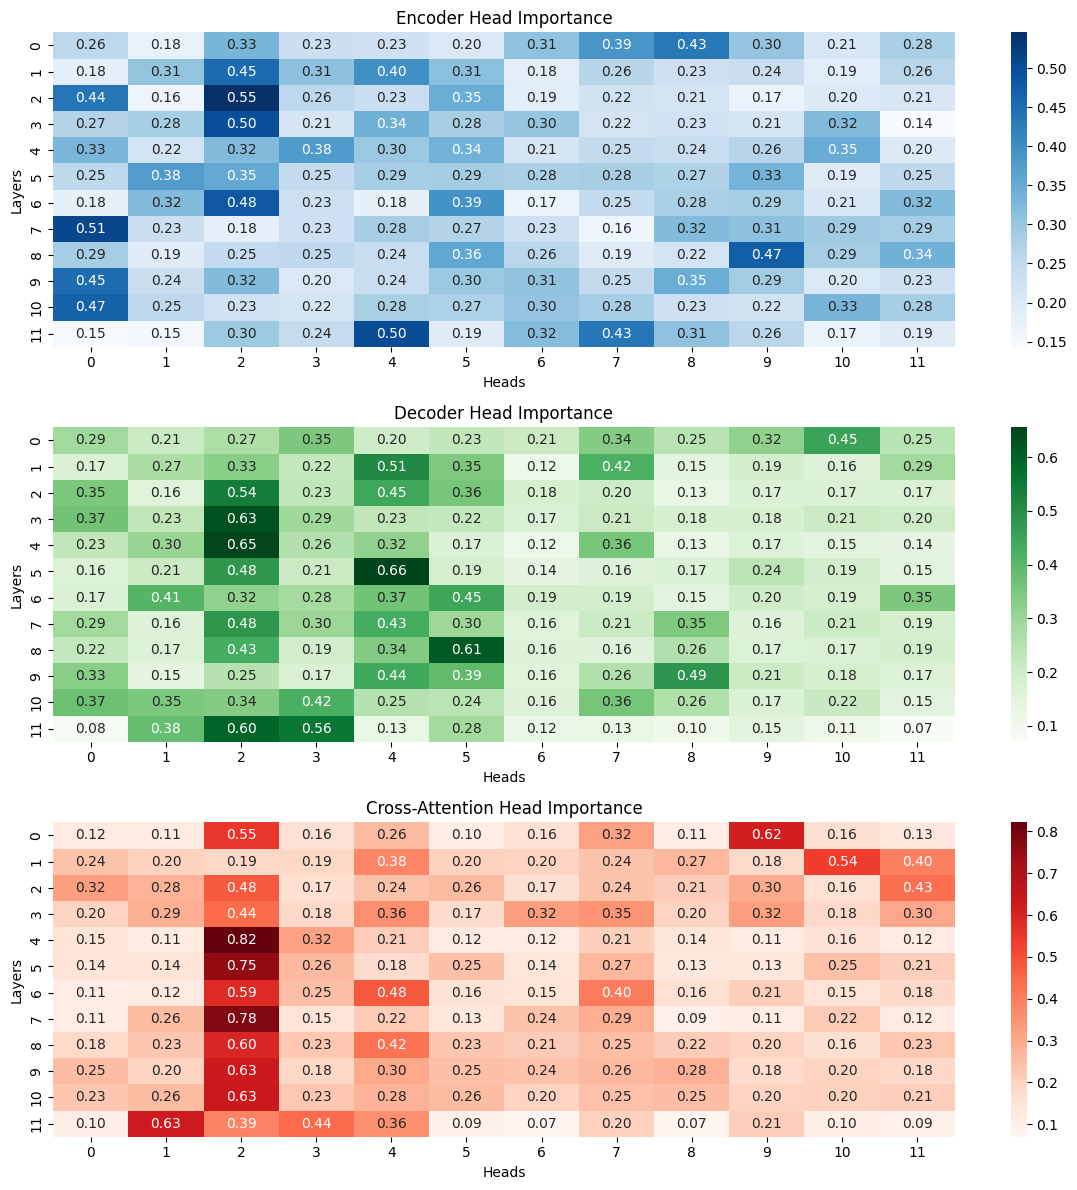

In [7]:
# Instantiate the class
ahi = AttentionHeadImportance()

# Load dataset and get dataloader
dataloader = ahi.get_dataloader("cnn_dailymail", "3.0.0", split=split_cnn_dailymail, batch_size=batch_size_cnn_dailymail)

# Compute head importance
encoder_importance, decoder_importance, cross_attn_importance = ahi.compute_head_importance(dataloader)

# Visualize
ahi.visualize_head_importance(encoder_importance, decoder_importance, cross_attn_importance, save_path="head_imp_cnn.png")


### Evaluate Head Importance on Translation task.

README.md:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

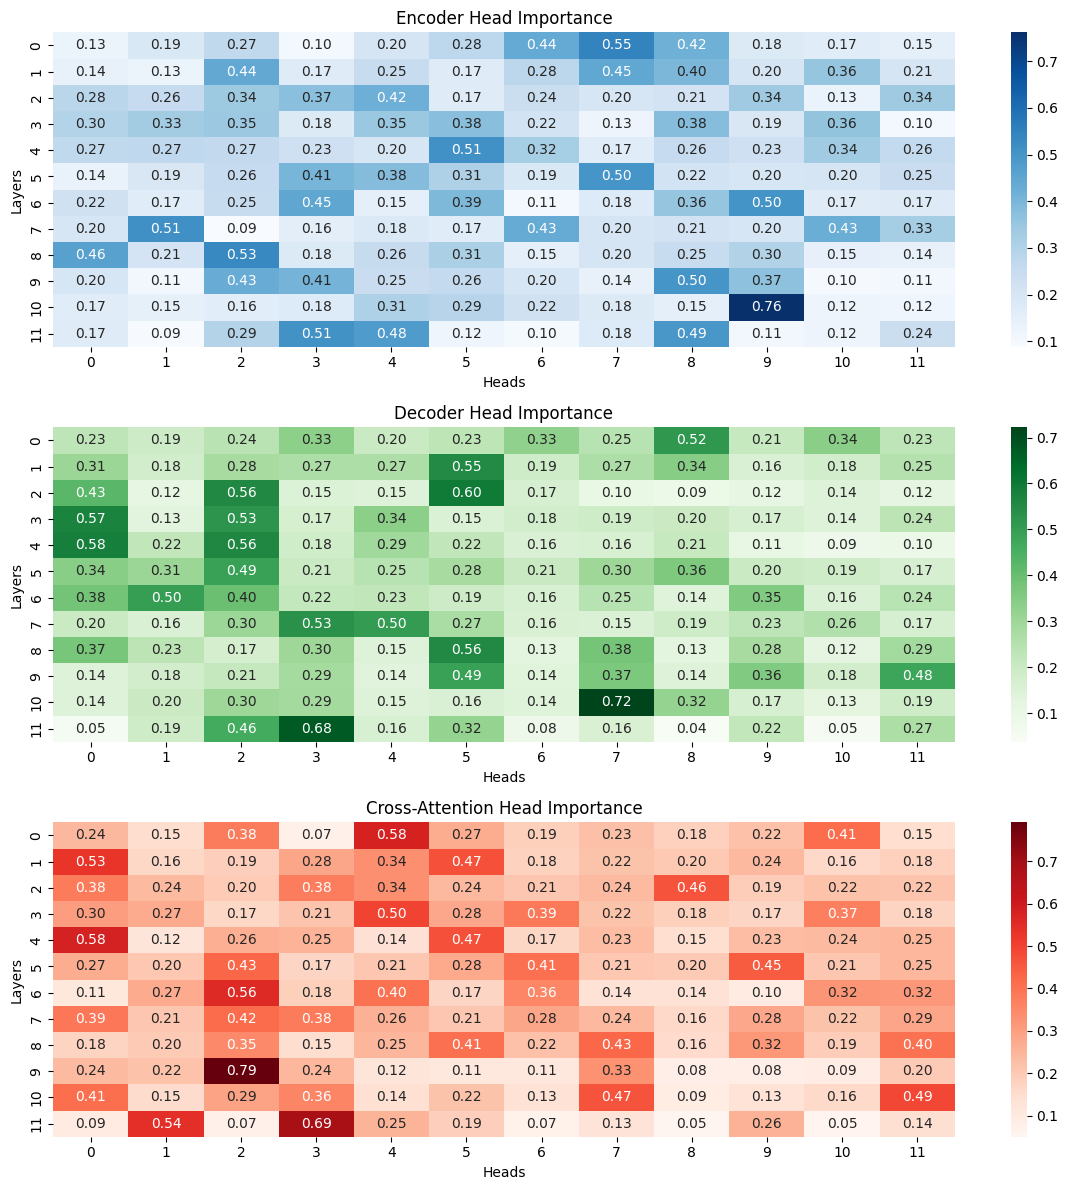

In [8]:
# Load dataset and get dataloader
dataloader = ahi.get_dataloader("wmt16", "de-en", split=split_wmt16, batch_size=batch_size_wmt16)
# Compute head importance
encoder_importance, decoder_importance, cross_attn_importance = ahi.compute_head_importance(dataloader)
# Visualize
ahi.visualize_head_importance(encoder_importance, decoder_importance, cross_attn_importance, save_path="head_imp_wmt.png")

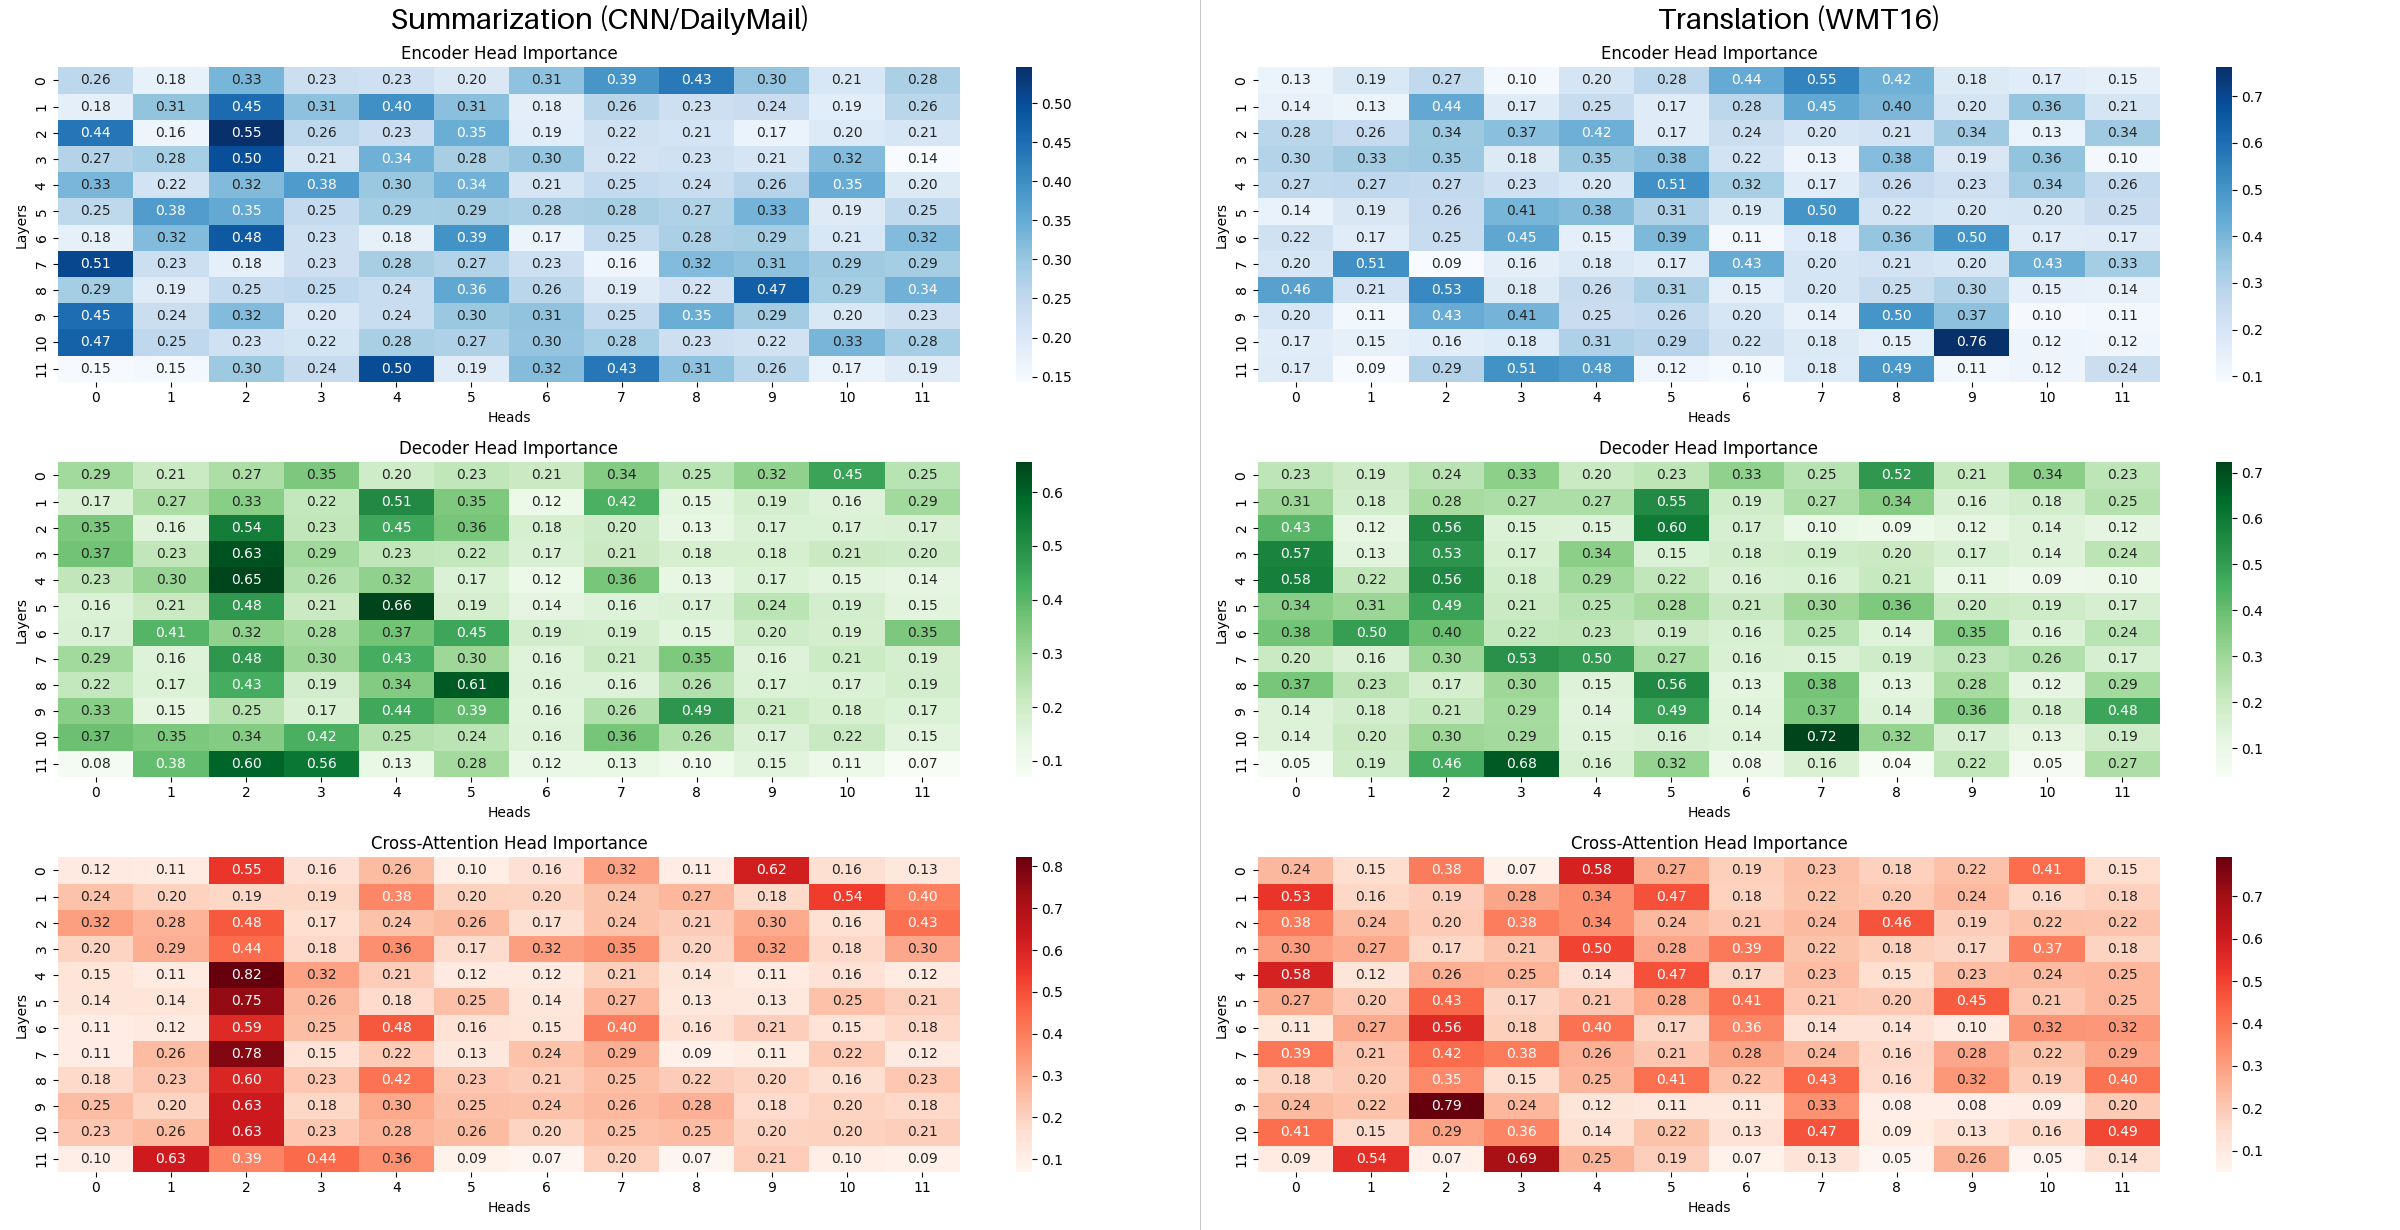

In [9]:
# Load the saved images
img1 = Image.open("head_imp_cnn.png")
img2 = Image.open("head_imp_wmt.png")

# Get dimensions
combined_width = img1.width + img2.width
max_height = max(img1.height, img2.height)

# Create a blank image with the combined width and extra space for labels
combined_img = Image.new("RGB", (combined_width, max_height + 30), (255, 255, 255))  # White background with space for labels

# Paste the images side by side
combined_img.paste(img1, (0, 30))  # Add 30px padding at top for labels
combined_img.paste(img2, (img1.width, 30))

# Add labels
draw = ImageDraw.Draw(combined_img)
font = ImageFont.load_default(size=30)

# Add titles centered above each image
draw.text((img1.width//2, 5), "Summarization (CNN/DailyMail)", fill=(0, 0, 0), font=font, anchor="mt")
draw.text((img1.width + img2.width//2, 5), "Translation (WMT16)", fill=(0, 0, 0), font=font, anchor="mt")

# Draw a subtle separator line
draw.line([(img1.width, 0), (img1.width, max_height + 30)], fill=(200, 200, 200), width=1)

# Show the combined image
display.display(combined_img)

### Expected Observations

When analyzing the attention head importance scores across different tasks like summarization (CNN/DailyMail) and translation (WMT16), you should observe several interesting patterns:

1. **Task-Specific Heads**: Some attention heads will show dramatically different importance scores between tasks. For example, certain encoder heads might be crucial for capturing the document structure in summarization but less important for the sentence-level processing in translation. This task-specific specialization suggests that different heads learn to focus on linguistic features relevant to particular tasks.

2. **Universally Important Heads**: You'll likely identify a subset of heads with consistently high importance scores across both tasks. These "universal" heads may be responsible for fundamental language understanding capabilities like syntactic parsing or semantic relationship modeling that benefit multiple NLP tasks.


## Pruning (Masking) Heads

In [10]:
## ==== BEGIN EVALUATION PORTION
class Pruner(AttentionHeadImportance):
    def get_mask(self, dataloader, sparsity_to_introduce, remove_from="any", existing_encoder_head_mask=None, existing_decoder_head_mask=None, existing_cross_attn_head_mask=None):
        """
        Creates attention head masks for pruning by removing/masking less important heads based on their importance scores.

        This method identifies which attention heads to prune based on their relative importance
        to the model's performance. Heads with lower importance scores are pruned first.

        Parameters:
        -----------
        dataloader : torch.utils.data.DataLoader
            A DataLoader containing batches of input data for evaluating head importance.
            Each batch should contain 'input_ids' and 'labels' for the model.

        sparsity_to_introduce : float
            The fraction of total heads to prune (e.g., 0.2 for 20% of heads).
            Must be between 0.0 and 1.0.

        remove_from : str, optional (default="any")
            Which component(s) to prune heads from. Must be one of:
            - "encoder": Only prune encoder self-attention heads
            - "decoder": Only prune decoder self-attention heads
            - "cross": Only prune cross-attention heads
            - "any": Prune from any component based on lowest importance scores

        existing_encoder_head_mask : torch.Tensor or None, optional
            Existing mask for encoder self-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        existing_decoder_head_mask : torch.Tensor or None, optional
            Existing mask for decoder self-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        existing_cross_attn_head_mask : torch.Tensor or None, optional
            Existing mask for cross-attention heads of shape (num_layers, num_heads).
            Contains 0s and 1s, where 1 indicates the head is active and 0 indicates the head is masked/pruned.
            If None, initialized with all heads active (all ones).

        Returns:
        --------
        tuple of (torch.Tensor, torch.Tensor, torch.Tensor)
            A tuple containing three binary mask tensors (0s and 1s):
            1. encoder_head_mask : torch.Tensor of shape (num_layers, num_heads)
            Binary mask for encoder self-attention heads, where 0 indicates pruned heads.
            2. decoder_head_mask : torch.Tensor of shape (num_layers, num_heads)
            Binary mask for decoder self-attention heads, where 0 indicates pruned heads.
            3. cross_attn_head_mask : torch.Tensor of shape (num_layers, num_heads)
            Binary mask for cross-attention heads, where 0 indicates pruned heads.

        Notes:
        ------
        - Utilise compute_head_importance().
        - The resulting masks will be used with the model to evaluate performance with pruned heads.
        - When remove_from="any", remove heads with the lowest importance scores across all components. For example, if sparsity_to_introduce=0.2, then our intention is to remove 20% of the total heads across from any part of the model, from amongst the active heads.
        - If our model has 100 heads in total, and 10 of those are already pruned (as per existing masks), and sparsity_to_introduce=0.2, then we will remove 20% of the original number of heads (i.e., 20% of 100 heads) in the current method call. Hence, the returned masks will have a sparsity of 30% (10 existing + 20 new).
        - When remove_from="encoder", "decoder", or "cross", remove heads only from the specified component. A sparsity of 0.2 means 20% of the heads in that component will be pruned.

        """
        # BEGIN CODE : pruner.get_mask
        # ADD YOUR CODE HERE

        # Compute head importance
        encoder_importance, decoder_importance, cross_attn_importance = self.compute_head_importance(dataloader, 
                                                                                                     existing_encoder_head_mask, 
                                                                                                     existing_decoder_head_mask, 
                                                                                                     existing_cross_attn_head_mask)
        #Handles the case wherein the existing masks are None.
        if existing_encoder_head_mask is None:
            existing_encoder_head_mask = torch.ones_like(encoder_importance, dtype=torch.float32, device=encoder_importance.device)
        if existing_decoder_head_mask is None:
            existing_decoder_head_mask = torch.ones_like(decoder_importance, dtype=torch.float32, device=decoder_importance.device)
        if existing_cross_attn_head_mask is None:
            existing_cross_attn_head_mask = torch.ones_like(cross_attn_importance, dtype=torch.float32, device=cross_attn_importance.device)

        
        #For Encoder only based pruning
        if remove_from == "encoder":
          num_layers, num_heads = encoder_importance.shape  # or decoder/cross depending
          num_heads_to_remove = int(num_layers * num_heads * sparsity_to_introduce)
            
          #Identify the the least important heads from the model based on the sparsity, not including ones that are already removed
          encoder_head_mask_updated = torch.ones_like(existing_encoder_head_mask, device=existing_encoder_head_mask.device)

          #Make the cell which are masked in the existing mask have a very high value
          encoder_head_mask_updated[existing_encoder_head_mask == 0] = 0
          encoder_importance[existing_encoder_head_mask == 0] = float('inf')

          # encoder_importance dim (num_layers, num_heads)
          encoder_heads_to_remove = torch.topk(encoder_importance.flatten(), num_heads_to_remove, largest=False).indices
          for i in encoder_heads_to_remove:
            layer, head = i // encoder_importance.shape[1], i % encoder_importance.shape[1]
            encoder_head_mask_updated[layer, head] = 0
          existing_encoder_head_mask = encoder_head_mask_updated
        
        #For Decoder only based pruning
        elif remove_from == "decoder":
          num_layers, num_heads = decoder_importance.shape  # decoder/cross depending
          num_heads_to_remove = int(num_layers * num_heads * sparsity_to_introduce)
            
          #Identify the the least important heads from the model based on the sparsity, not including ones that are already removed
          decoder_head_mask_updated = torch.ones_like(existing_decoder_head_mask, device=existing_encoder_head_mask.device)

          #Make the cell which are masked in the existing mask have a very high value
          decoder_head_mask_updated[existing_decoder_head_mask == 0] = 0
          decoder_importance[existing_decoder_head_mask == 0] = float('inf')

          # decoder_importance dim (num_layers, num_heads)
          decoder_heads_to_remove = torch.topk(decoder_importance.flatten(), num_heads_to_remove, largest=False).indices
          for i in decoder_heads_to_remove:
            layer, head = i // decoder_importance.shape[1], i % decoder_importance.shape[1]
            decoder_head_mask_updated[layer, head] = 0
          existing_decoder_head_mask = decoder_head_mask_updated

        #For Cross-Attetion based pruning
        elif remove_from == "cross":
          num_layers, num_heads = cross_attn_importance.shape  # decoder/cross depending
          num_heads_to_remove = int(num_layers * num_heads * sparsity_to_introduce)
            
          #Identify the the least important heads from the model based on the sparsity, not including ones that are already removed
          cross_attn_head_mask_updated = torch.ones_like(existing_cross_attn_head_mask, device=existing_cross_attn_head_mask.device)

          #Make the cell which are masked in the existing mask have a very high value
          cross_attn_head_mask_updated[existing_cross_attn_head_mask == 0] = 0
          cross_attn_importance[existing_cross_attn_head_mask == 0] = float('inf')

          # cross_attn_importance dim (num_layers, num_heads)
          cross_attn_heads_to_remove = torch.topk(cross_attn_importance.flatten(), num_heads_to_remove, largest=False).indices
          for i in cross_attn_heads_to_remove:
            layer, head = i // cross_attn_importance.shape[1], i % cross_attn_importance.shape[1]
            cross_attn_head_mask_updated[layer, head] = 0
          existing_cross_attn_head_mask = cross_attn_head_mask_updated
        
        #Prune from any component based on lowest importance scores
        else:
          #Calculate the number of heads to prune
          num_layers_encoder, num_heads_encoder = encoder_importance.shape
          num_layers_decoder, num_heads_decoder = decoder_importance.shape
          num_heads_to_remove = int((num_layers_encoder * num_heads_encoder + num_layers_decoder * num_heads_decoder * 2) * sparsity_to_introduce)
          
          #Create a dummy matrices for all three 
          dummy_matrix_encoder = torch.ones_like(existing_encoder_head_mask, device=existing_encoder_head_mask.device)
          dummy_matrix_decoder = torch.ones_like(existing_decoder_head_mask, device=existing_decoder_head_mask.device)
          dummy_matrix_cross = torch.ones_like(existing_cross_attn_head_mask, device=existing_cross_attn_head_mask.device)
          
          #Make the values in dummy, which are already masked, masked.
          dummy_matrix_encoder[existing_encoder_head_mask == 0] = 0
          dummy_matrix_decoder[existing_decoder_head_mask == 0] = 0
          dummy_matrix_cross[existing_cross_attn_head_mask == 0] = 0
            
          #Make the cell which are masked in the existing mask have a very high value
          encoder_importance[existing_encoder_head_mask == 0] = float('inf')
          decoder_importance[existing_decoder_head_mask == 0] = float('inf')
          cross_attn_importance[existing_cross_attn_head_mask == 0] = float('inf')

          # Stack each of the dummy and importance matrices on top of each other
          dummy_matrix = torch.stack([dummy_matrix_encoder, dummy_matrix_decoder, dummy_matrix_cross])
          combined_importance = torch.stack([encoder_importance, decoder_importance, cross_attn_importance])

          #Identify the the least important heads from the model based on sparcity
          all_heads_to_remove = torch.topk(combined_importance.flatten(), num_heads_to_remove, largest=False).indices
          a, b, c = combined_importance.size()
          for i in all_heads_to_remove:
            type_is = i // (b * c)
            layer = (i % (b * c)) // c
            head = i % c
            dummy_matrix[type_is, layer, head] = 0
          #Assign the updated masks to existing
          existing_encoder_head_mask = dummy_matrix[0]
          existing_decoder_head_mask = dummy_matrix[1]
          existing_cross_attn_head_mask = dummy_matrix[2]

        return existing_encoder_head_mask, existing_decoder_head_mask, existing_cross_attn_head_mask
    
        # END CODE
## ==== END EVALUATION PORTION

### EVALUATION OF THE PRUNING STRATEGY

In [11]:

def evaluate_at_different_sparsities(pruner, train_dataloader, test_dataloader, sparsities=[0, 0.2, 0.4, 0.6, 0.8, 1.0], remove_from="any"):

    encoder_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)
    decoder_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)
    cross_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)

    bleu_scores = []
    cur_sparsity = 0

    for sparsity in sparsities:

        sparsity_to_introduce = sparsity - cur_sparsity
        encoder_mask, decoder_mask, cross_mask = pruner.get_mask(train_dataloader, sparsity_to_introduce, remove_from=remove_from, existing_encoder_head_mask=encoder_mask, existing_decoder_head_mask=decoder_mask, existing_cross_attn_head_mask=cross_mask)

        cur_sparsity = sparsity
        print(f"Performing evaluation when sparsity={sparsity}")
        cur_bleu_scores = []

        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(pruner.device)
            labels = batch["labels"].to(pruner.device)

            output_ids = pruner.model.generate(
                input_ids,
                head_mask=encoder_mask,
                decoder_head_mask=decoder_mask,
                cross_attn_head_mask=cross_mask,
                max_length=50,
                num_beams=5,
                early_stopping=True
            )

            for i in range(len(input_ids)):
                prompt = pruner.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                reference = pruner.tokenizer.decode(labels[i], skip_special_tokens=True)
                candidate = pruner.tokenizer.decode(output_ids[i], skip_special_tokens=True)
                cur_bleu_scores.append(bleu_score(candidate, reference))

        average_bleu = sum(cur_bleu_scores) / len(cur_bleu_scores)
        bleu_scores.append(average_bleu)
    return bleu_scores

In [12]:
torch.manual_seed(42)

pruner = Pruner(model_name="t5-base")
dataloader_wmt = pruner.get_dataloader("wmt16", "de-en", split="validation[:5%]", batch_size=8) # this dataloader will be used for calculating the masks
dataloader_wmt_test = pruner.get_dataloader("wmt16", "de-en", split="test[:5%]", batch_size=8)

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

#### Pruning heads from any part of the model

Performing evaluation when sparsity=0
Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1

Sparsity vs BLEU Score
Sparsity: 0.0  |  BLEU Score: 0.3822
Sparsity: 0.2  |  BLEU Score: 0.3774
Sparsity: 0.4  |  BLEU Score: 0.2468
Sparsity: 0.6  |  BLEU Score: 0.0633
Sparsity: 0.8  |  BLEU Score: 0.0479
Sparsity: 1.0  |  BLEU Score: 0.0010


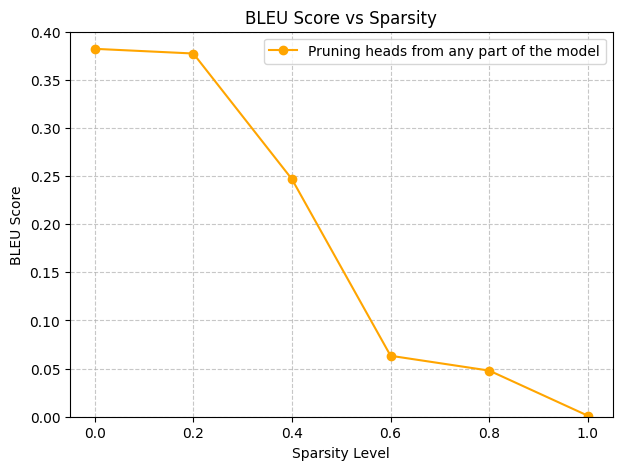

In [13]:
torch.manual_seed(42)

sparsities = [0, 0.2, 0.4, 0.6, 0.8, 1]

bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="any")

# Print results in a formatted table
print("\nSparsity vs BLEU Score")
print("=" * 30)
for sparsity, score in zip(sparsities, bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

# Plot BLEU Score vs Sparsity
plt.figure(figsize=(7, 5))
plt.plot(sparsities, bleu_scores, marker='o', linestyle='-', color='orange', label="Pruning heads from any part of the model")
plt.xlabel("Sparsity Level")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Sparsity")
plt.ylim(0, 0.40)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(sparsities)
plt.savefig('prune_any.png')

score_no_sparsity = bleu_scores[0]

### Expected Observations

The bleu score will decrease as the sparsity increases but you should observe that using carefully curated masks would result in atleast 20-30% better bleu scores than random masking for 50% sparsity. As the degree of sparsity increases, the relative performance improvement should increase significantly.

#### Pruning heads from individual components

Masking heads in the encoder layers only...

Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1.0

Encoder Sparsity vs BLEU Score
Sparsity: 0.2  |  BLEU Score: 0.3931
Sparsity: 0.4  |  BLEU Score: 0.3748
Sparsity: 0.6  |  BLEU Score: 0.2984
Sparsity: 0.8  |  BLEU Score: 0.1823
Sparsity: 1.0  |  BLEU Score: 0.0320

Masking heads in the decoder layers only...

Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1.0

Decoder Sparsity vs BLEU Score
Sparsity: 0.2  |  BLEU Score: 0.3785
Sparsity: 0.4  |  BLEU Score: 0.3705
Sparsity: 0.6  |  BLEU Score: 0.3728
Sparsity: 0.8  |  BLEU Score: 0.2150
Sparsity: 1.0  |  BLEU Score: 0.0828

Masking cross-attention heads only...

Performing evaluation when sparsity

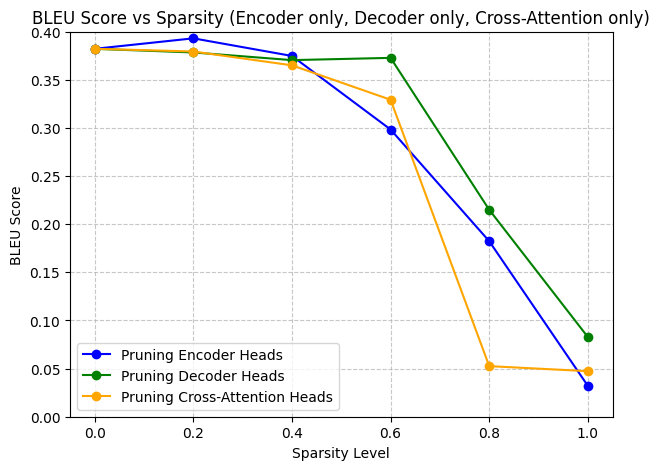

In [14]:
torch.manual_seed(42)
sparsities = [0.2, 0.4, 0.6, 0.8, 1.0]

print("Masking heads in the encoder layers only...\n")
encoder_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="encoder")

print("\nEncoder Sparsity vs BLEU Score")
print("=" * 30)

for sparsity, score in zip(sparsities, encoder_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

torch.manual_seed(42)

print("\nMasking heads in the decoder layers only...\n")
decoder_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="decoder")

print("\nDecoder Sparsity vs BLEU Score")
print("=" * 30)

for sparsity, score in zip(sparsities, decoder_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

torch.manual_seed(42)

print("\nMasking cross-attention heads only...\n")
cross_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="cross")

print("\nCross-Attention Sparsity vs BLEU Score")
print("=" * 30)
for sparsity, score in zip(sparsities, cross_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

# Prepend and append the scores for no sparsity and total sparsity
encoder_bleu_scores.insert(0, score_no_sparsity)

decoder_bleu_scores.insert(0, score_no_sparsity)

cross_bleu_scores.insert(0, score_no_sparsity)

sparsities.insert(0, 0)

plt.figure(figsize=(7, 5))
plt.plot(sparsities, encoder_bleu_scores,
         marker='o', linestyle='-', color='blue', label="Pruning Encoder Heads")
plt.plot(sparsities, decoder_bleu_scores,
         marker='o', linestyle='-', color='green', label="Pruning Decoder Heads")
plt.plot(sparsities, cross_bleu_scores,
         marker='o', linestyle='-', color='orange', label="Pruning Cross-Attention Heads")
plt.xlabel("Sparsity Level")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Sparsity (Encoder only, Decoder only, Cross-Attention only)")
plt.ylim(0, 0.40)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(sparsities)
plt.savefig('prune_encoder_decoder_cross.png')

### Expected Observations

You should see that the impact of pruning to different sparsity levels in different components (encoder, decoder, cross-attention) is not the same. Pruning a certain percentage from some component may result in a much larger performance degradation compared to pruning the same percentage from another component. Moreover, you might observe that when you prune carefully, the performance degradation from component A might be worse than that for component B. But when you prune randomly, the trend might switch. This may mean that certain components contain a higher concentration of critical heads whilst other components have their importance more evenly distributed across heads, making them more resilient to targeted pruning but potentially more vulnerable to random pruning.

# Congratulations!

You've reached the end of the assignment. Hope this was a pleasant and fun exercise!

Check the submission instructions mentioned at the beginning of the notebook in order to submit your homework.
